<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Intraday_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade arch

In [2]:
import warnings

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model  # pip install arch
from scipy.stats import percentileofscore, probplot
import seaborn as sns
from datetime import datetime, timedelta

In [4]:
warnings.filterwarnings("ignore")

In [5]:
ticker = 'NIFTYBEES.NS'
prev_day = 1
scale_factor = 10000
window_length = 60
prediction_length = 15
arima_order = (15, 1, 15)

garch_p = 10
garch_q = 10
garch_distribution = 'normal'

num_paths = 10000
paths_to_plot = 100

In [6]:
def download_data(ticker, prev_day):
    date = datetime.today().date() - timedelta(days = 1)

    start_date = date.strftime("%Y-%m-%d")
    end_date = (date + timedelta(days=1)).strftime("%Y-%m-%d")

    data = yf.download(ticker, start=start_date, end=end_date, interval="1m")

    if data.index.tzinfo is None:
        data.index = data.index.tz_localize('UTC')

    data.index = data.index.tz_convert('Asia/Kolkata')

    return data

In [7]:
def calculate_return(data, scale_factor):
    data_ = pd.DataFrame({
        'S' : data['Close'].values.reshape((-1,))
    }, index = data.index)

    data_.eval('log_S = log(S)', inplace = True)
    data_['scaled_return'] = scale_factor * data_['log_S'].diff()
    data_.dropna(inplace = True)

    return data_

In [8]:
def create_rolling_window(return_data, window_length):
    data_frame_list = []

    N = len(return_data)

    for idx in range(window_length, N - prediction_length):
        data_frame_list += [return_data.iloc[idx - window_length : idx]]

    return data_frame_list

In [9]:
def arima_garch(rolling_window_list, window_idx, return_index, plot = False, monte_calro_plot = False):
    window_data = rolling_window_list[window_idx]

    model = ARIMA(window_data[['scaled_return']], order=arima_order)
    model_fit = model.fit()
    if plot:
        print(model_fit.summary())

    N = len(return_index)

    # Create a date range for the forecast period (forecast_years from today)
    forecast_index = return_index[window_length + window_idx : window_length + window_idx + prediction_length]

    forecast_length = len(forecast_index)

    # Forecast percent log returns using ARIMA.
    forecast_results = model_fit.get_forecast(steps = forecast_length)
    forecast_mean = forecast_results.predicted_mean
    forecast_ci = forecast_results.conf_int()

    forecast_mean.index = forecast_index
    forecast_ci.index = forecast_index

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(window_data[['scaled_return']], label='Observed')
        plt.plot(forecast_mean, label='Forecast', color='red')
        plt.fill_between(forecast_ci.index,
                        forecast_ci.iloc[:, 0],
                        forecast_ci.iloc[:, 1],
                        color='pink', alpha=0.3, label='95% CI')
        plt.xlabel('Date')
        plt.ylabel('Scaled Log Return')
        plt.legend()
        plt.show()

    arima_resid = model_fit.resid.dropna()
    garch_model = arch_model(arima_resid, vol='Garch', p=garch_p, q=garch_q, dist=garch_distribution)
    garch_fit = garch_model.fit(disp='off')

    if plot:
        print(garch_fit.summary())


    garch_forecast = garch_fit.forecast(horizon=forecast_length)
    # Use the last available variance forecast.
    forecast_variance = garch_forecast.variance.iloc[-1]
    forecast_volatility = np.sqrt(forecast_variance)
    forecast_volatility.index = forecast_index

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(forecast_volatility, label='Forecasted Volatility')
        plt.title(f'GARCH Forecasted Volatility for {ticker}\n(Percent Scale)')
        plt.xlabel('Date')
        plt.ylabel('Volatility (%)')
        plt.legend()
        plt.show()

    last_log_price = window_data['log_S'].iloc[-1]

    # IMPORTANT: The ARIMA forecast is in percent; to convert to standard log returns, divide by 100.
    forecast_log_price = last_log_price + np.cumsum(forecast_mean / scale_factor)

    # For the envelope, add/subtract 2 times the forecasted volatility (in percent) then divide by 100.
    forecast_log_price_up = last_log_price + np.cumsum((forecast_mean + 2 * forecast_volatility) / scale_factor)
    forecast_log_price_down = last_log_price + np.cumsum((forecast_mean - 2 * forecast_volatility) / scale_factor)

    # Convert forecasted log prices back to the original price scale.
    forecast_price = np.exp(forecast_log_price)
    forecast_price_up = np.exp(forecast_log_price_up)
    forecast_price_down = np.exp(forecast_log_price_down)

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(data['Close'], label='Observed Price')
        plt.plot(forecast_index, forecast_price, label='Forecast Price', color='red')
        plt.fill_between(forecast_index,
                        forecast_price_down,
                        forecast_price_up,
                        color='pink', alpha=0.3, label='±2x Volatility Envelope')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    simulated_paths = pd.DataFrame(index=forecast_index, columns=range(num_paths))

    simulated_paths = pd.DataFrame(index=forecast_index, columns=range(num_paths))

    for path in range(num_paths):
        simulated_log_prices = []
        current_log_price = last_log_price
        for t in range(forecast_length):
            mu = forecast_mean.iloc[t]         # in percent
            sigma = forecast_volatility.iloc[t]  # in percent
            shock = mu + sigma * np.random.randn()
            current_log_price += shock / scale_factor    # convert percent to standard log return
            simulated_log_prices.append(current_log_price)
        simulated_paths[path] = np.exp(simulated_log_prices)

    # For plotting, randomly select a subset of simulation paths.
    np.random.seed(42)  # For reproducibility.
    selected_paths = np.random.choice(simulated_paths.columns, paths_to_plot, replace=False)

    ci_lower_forecast = simulated_paths.quantile(0.025, axis=1)
    ci_upper_forecast = simulated_paths.quantile(0.975, axis=1)

    if plot:
        plt.figure(figsize=(10, 4))
        for path in selected_paths:
            plt.plot(simulated_paths.index, simulated_paths[path], lw=1, alpha=0.8,
                    label='MC Path' if path == selected_paths[0] else None)
        plt.plot(data['Close'], label='Observed Price', color='black')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    if monte_calro_plot:
        plt.figure(figsize=(10, 6))
        # Plot the ARIMA-based forecast price (or any central measure, e.g., the median of the simulations)
        median_forecast = simulated_paths.median(axis=1)
        plt.plot(forecast_index, median_forecast, label="Median Monte Carlo Forecast", color='red', linewidth=2)
        # Fill between the lower and upper percentiles
        plt.fill_between(forecast_index, ci_lower_forecast, ci_upper_forecast, color='gray', alpha=0.3, label="95% Confidence Interval")
        plt.plot(data['Close'], label='Observed Price', color='black')
        plt.title("95% Confidence Interval for Price Forecast (Monte Carlo)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    current_price = window_data['S'].iloc[-1]

    if plot:
        print(current_price)

    final_prices = simulated_paths.iloc[-1]

    simulated_returns = 100 * (final_prices - current_price) / current_price

    confidence_level = 0.95
    alpha = 1 - confidence_level  # 0.05
    var_threshold = np.percentile(simulated_returns, 100 * alpha)  # 5th percentile
    expected_shortfall = simulated_returns[simulated_returns <= var_threshold].mean()

    current_price_percentile = percentileofscore(final_prices, current_price)
    prob_profit = 100 - current_price_percentile

    if monte_calro_plot:
        print(f"Value at Risk (95% confidence level): {var_threshold:.2f}%")
        print(f"Expected Shortfall (95% confidence level): {expected_shortfall:.2f}%")
        print(f"Probability of Profit (Final Price > Current Price): {prob_profit:.2f}%")

    return [[var_threshold, expected_shortfall, prob_profit]]

In [10]:
data = download_data(ticker, prev_day)
return_data = calculate_return(data, scale_factor)
N = len(return_data)
return_index = return_data.index
rolling_window_list = create_rolling_window(return_data, window_length)

[*********************100%***********************]  1 of 1 completed


                               SARIMAX Results                                
Dep. Variable:          scaled_return   No. Observations:                   60
Model:               ARIMA(15, 1, 15)   Log Likelihood                -164.440
Date:                Thu, 13 Feb 2025   AIC                            390.880
Time:                        18:45:46   BIC                            455.284
Sample:                    02-12-2025   HQIC                           416.021
                         - 02-12-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5591      1.150     -0.486      0.627      -2.812       1.694
ar.L2         -0.0888      0.552     -0.161      0.872      -1.171       0.994
ar.L3         -1.1451      0.639     -1.791      0.0

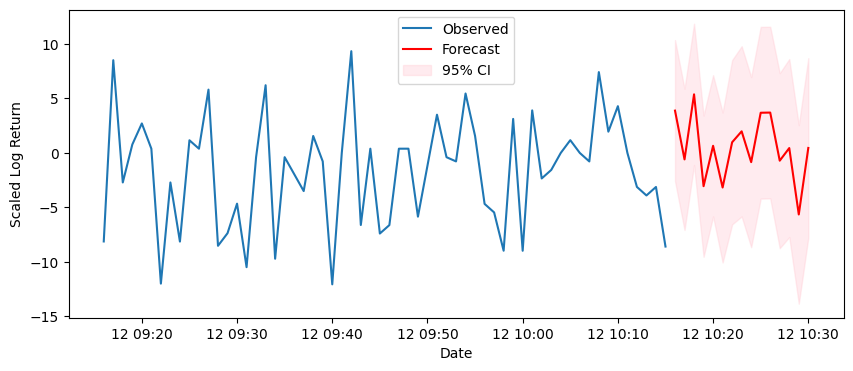

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -163.928
Distribution:                  Normal   AIC:                           371.856
Method:            Maximum Likelihood   BIC:                           417.932
                                        No. Observations:                   60
Date:                Thu, Feb 13 2025   Df Residuals:                       59
Time:                        18:45:47   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1675      2.707  6.188e-02      0.951 [ -5.138,  5.47

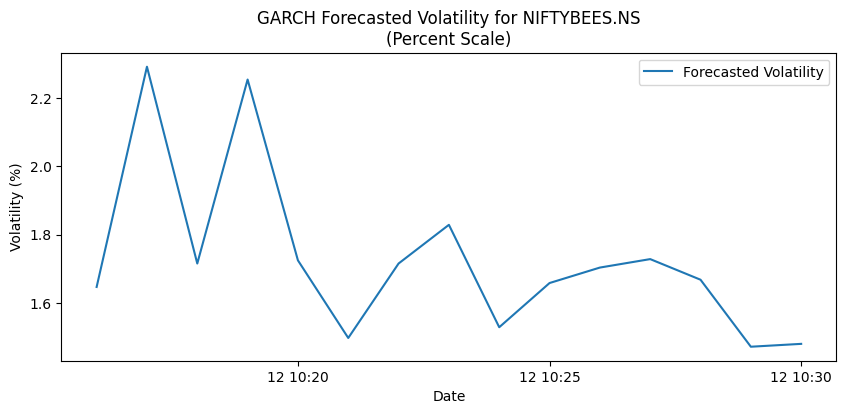

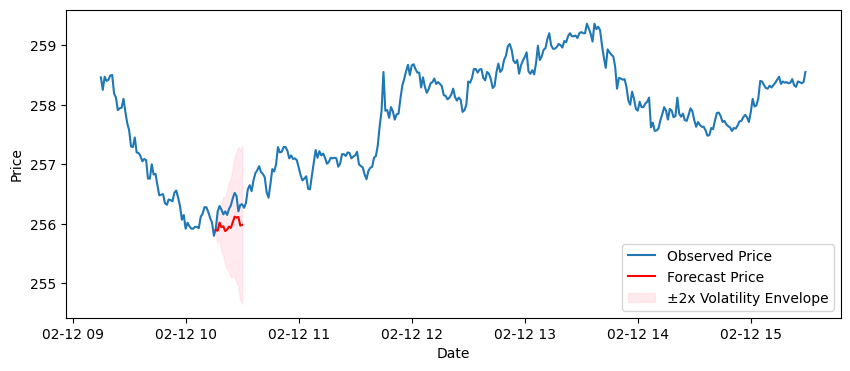

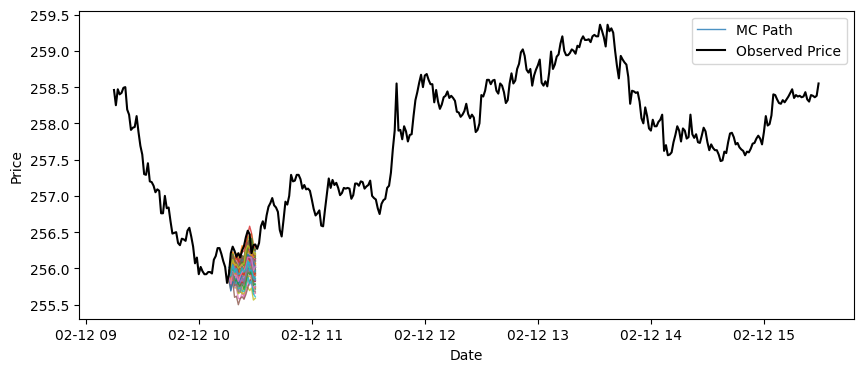

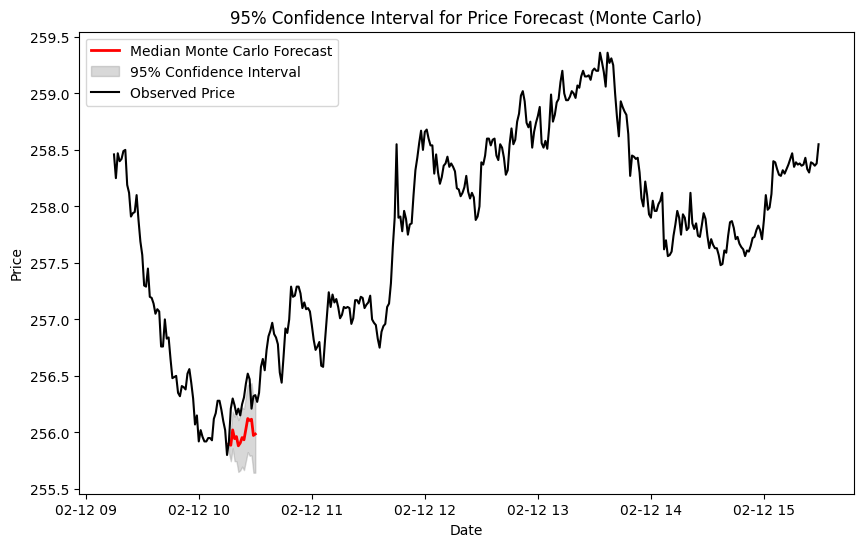

255.8000030517578
Value at Risk (95% confidence level): -0.04%
Expected Shortfall (95% confidence level): -0.07%
Probability of Profit (Final Price > Current Price): 85.96%


[[-0.038984320422563785, -0.06781741511348073, 85.96]]

In [11]:
arima_garch(rolling_window_list, 0, return_index, plot = True, monte_calro_plot = True)

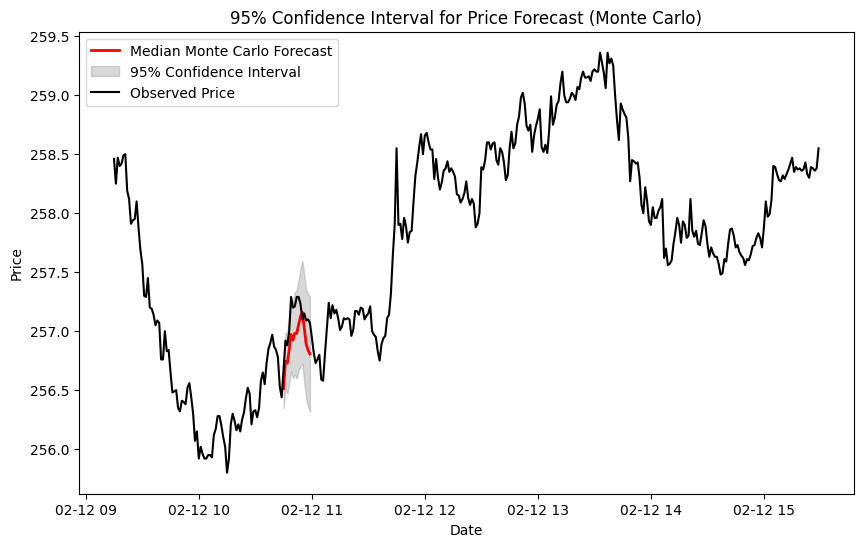

Value at Risk (95% confidence level): -0.02%
Expected Shortfall (95% confidence level): -0.06%
Probability of Profit (Final Price > Current Price): 92.91%


[[-0.016861846306988882, -0.05744021425191606, 92.91]]

In [12]:
arima_garch(rolling_window_list, 29, return_index, monte_calro_plot = True)

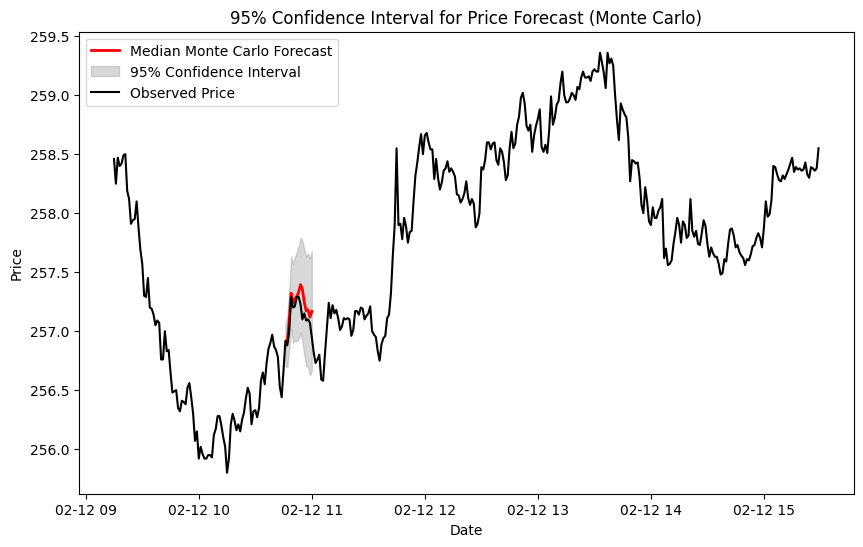

Value at Risk (95% confidence level): 0.03%
Expected Shortfall (95% confidence level): -0.01%
Probability of Profit (Final Price > Current Price): 97.26%


[[0.02737662976610679, -0.01398205775370538, 97.26]]

In [13]:
arima_garch(rolling_window_list, 30, return_index, monte_calro_plot = True)

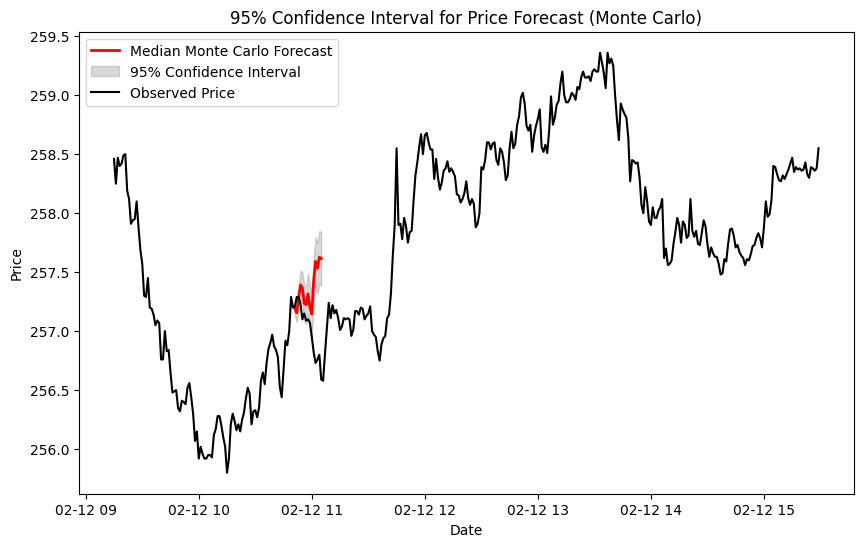

Value at Risk (95% confidence level): 0.09%
Expected Shortfall (95% confidence level): 0.07%
Probability of Profit (Final Price > Current Price): 99.98%


[[0.08647874671966467, 0.06786166891558937, 99.98]]

In [14]:
arima_garch(rolling_window_list, 35, return_index, monte_calro_plot = True)

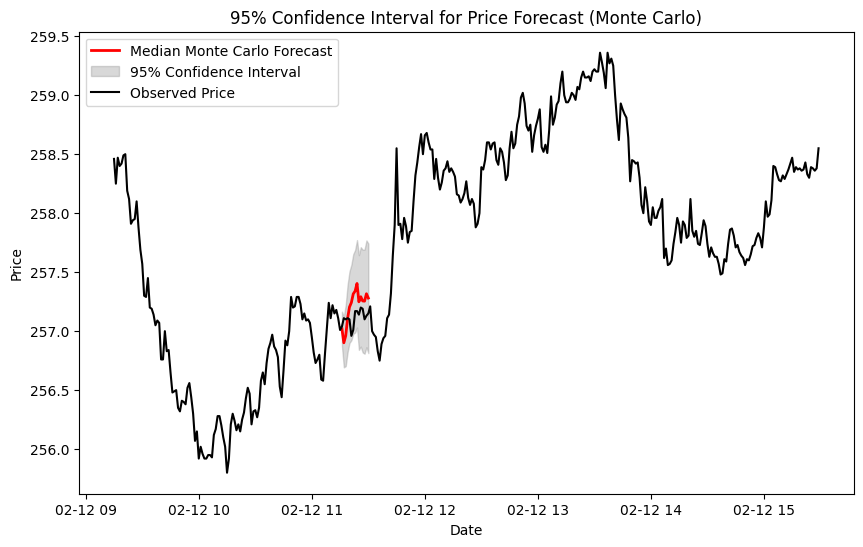

Value at Risk (95% confidence level): -0.04%
Expected Shortfall (95% confidence level): -0.08%
Probability of Profit (Final Price > Current Price): 87.28%


[[-0.04485422335196259, -0.0839033092805241, 87.28]]

In [15]:
arima_garch(rolling_window_list, 60, return_index, monte_calro_plot = True)

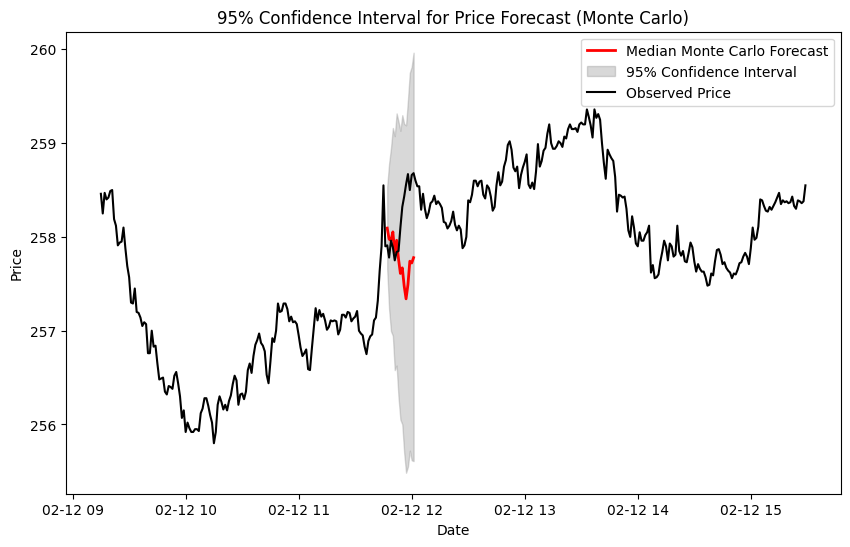

Value at Risk (95% confidence level): -0.77%
Expected Shortfall (95% confidence level): -0.94%
Probability of Profit (Final Price > Current Price): 45.60%


[[-0.7693264790541103, -0.9364594048005067, 45.6]]

In [16]:
arima_garch(rolling_window_list, 91, return_index, monte_calro_plot = True)

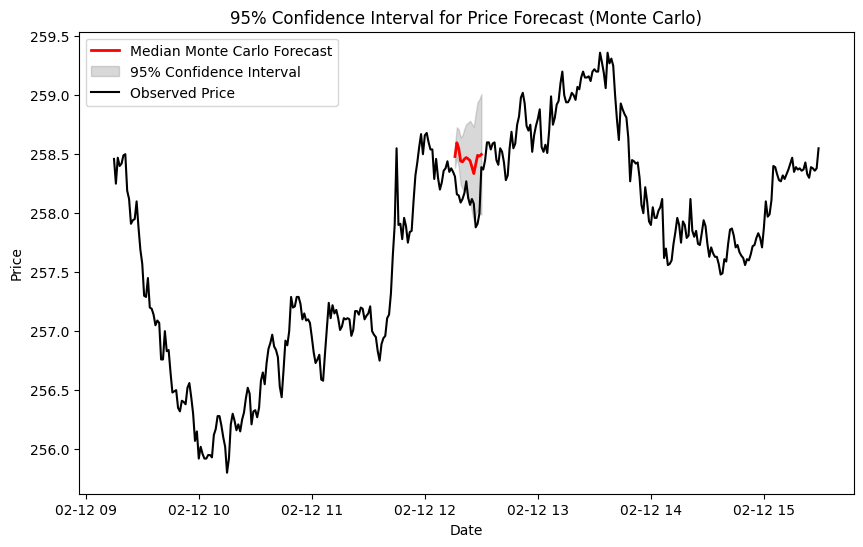

Value at Risk (95% confidence level): -0.11%
Expected Shortfall (95% confidence level): -0.15%
Probability of Profit (Final Price > Current Price): 70.96%


[[-0.10889852562518547, -0.15048321946139442, 70.96000000000001]]

In [17]:
arima_garch(rolling_window_list, 120, return_index, monte_calro_plot = True)

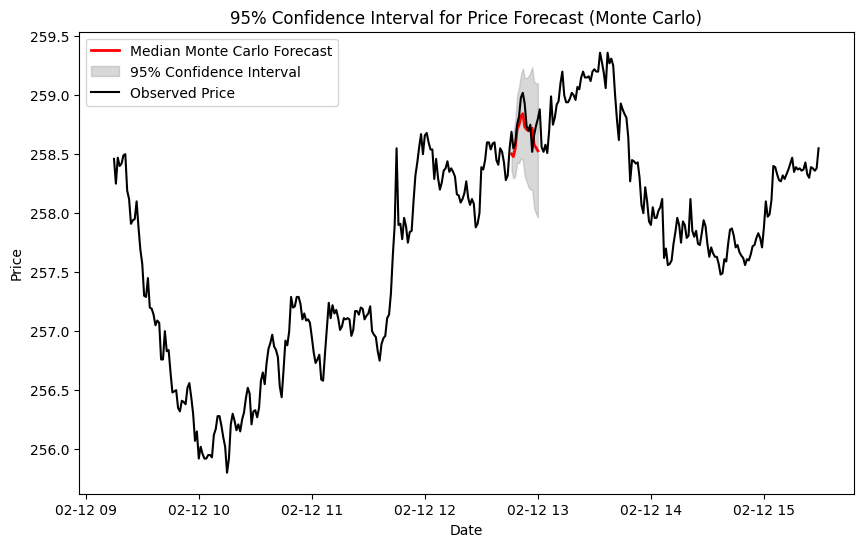

Value at Risk (95% confidence level): -0.19%
Expected Shortfall (95% confidence level): -0.24%
Probability of Profit (Final Price > Current Price): 47.11%


[[-0.1939195763209974, -0.23996859168925794, 47.11]]

In [18]:
arima_garch(rolling_window_list, 150, return_index, monte_calro_plot = True)

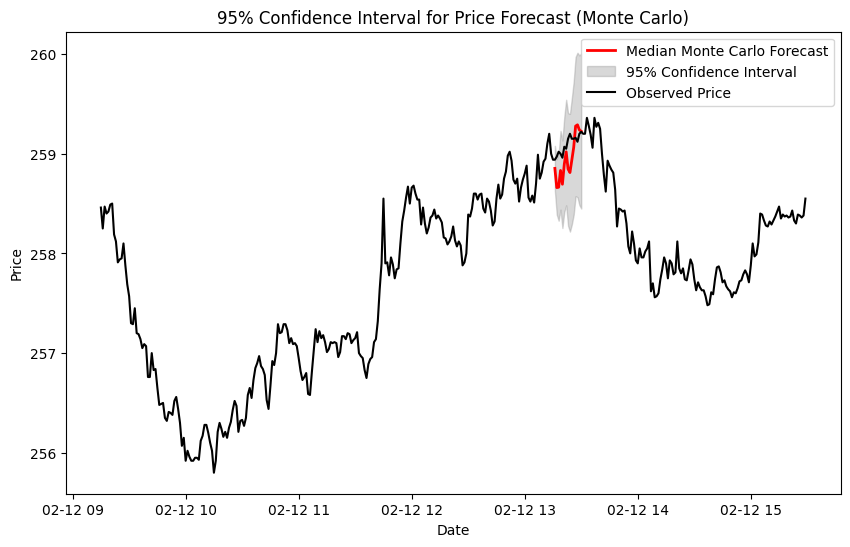

Value at Risk (95% confidence level): -0.14%
Expected Shortfall (95% confidence level): -0.21%
Probability of Profit (Final Price > Current Price): 75.87%


[[-0.14369813909561707, -0.20505879212621272, 75.87]]

In [19]:
arima_garch(rolling_window_list, 180, return_index, monte_calro_plot = True)

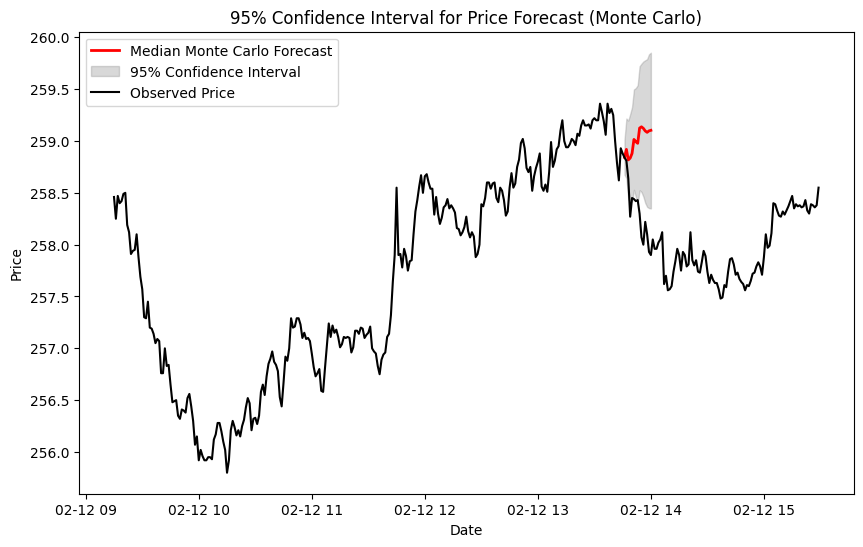

Value at Risk (95% confidence level): -0.16%
Expected Shortfall (95% confidence level): -0.22%
Probability of Profit (Final Price > Current Price): 70.88%


[[-0.16254594613072512, -0.22300207433991742, 70.88]]

In [20]:
arima_garch(rolling_window_list, 210, return_index, monte_calro_plot = True)

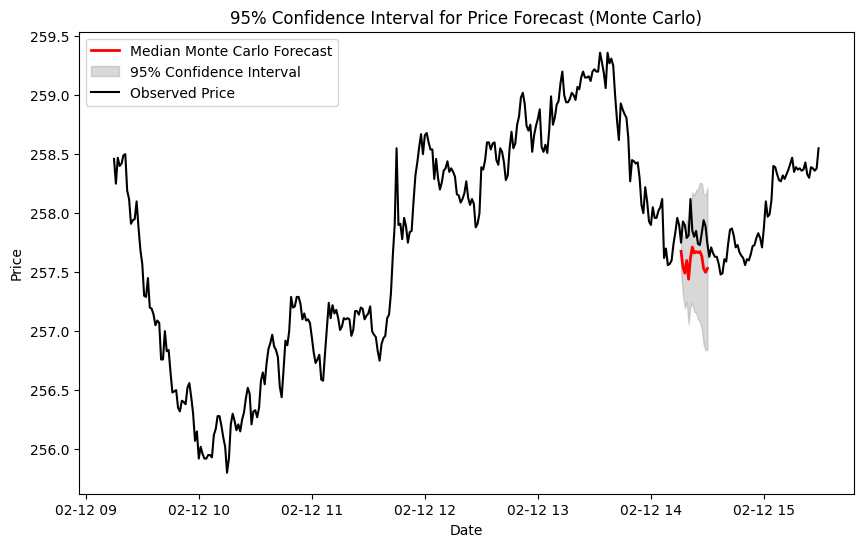

Value at Risk (95% confidence level): -0.37%
Expected Shortfall (95% confidence level): -0.42%
Probability of Profit (Final Price > Current Price): 14.94%


[[-0.3668879380390721, -0.421889660280898, 14.939999999999998]]

In [21]:
arima_garch(rolling_window_list, 240, return_index, monte_calro_plot = True)

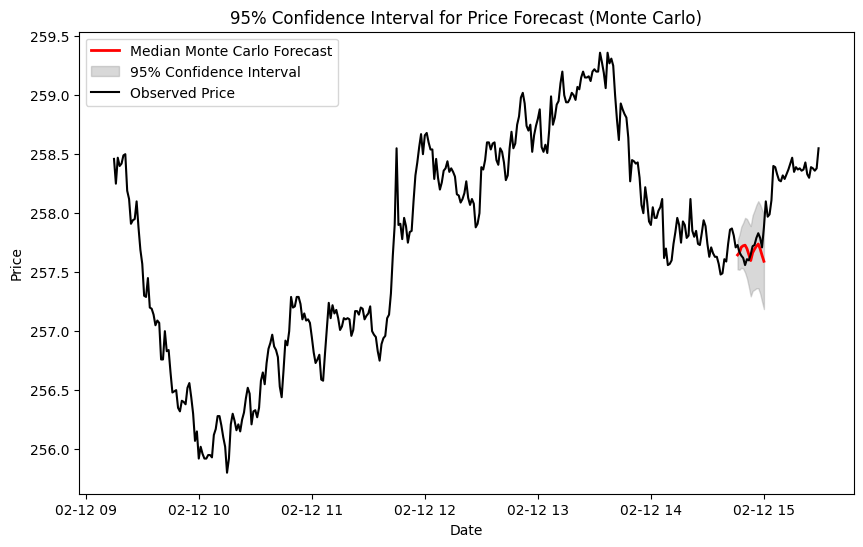

Value at Risk (95% confidence level): -0.18%
Expected Shortfall (95% confidence level): -0.21%
Probability of Profit (Final Price > Current Price): 28.54%


[[-0.17913754237609483, -0.21105890275274639, 28.539999999999992]]

In [22]:
arima_garch(rolling_window_list, 270, return_index, monte_calro_plot = True)

In [23]:
M = len(rolling_window_list)

In [24]:
M

299